In [138]:
import pandas as pd 
import psycopg2
import matplotlib.pyplot as plt
import numpy as np
import ast

In [126]:
# Load mode
load_mode = 'csv' #csv or db
csv_filename = 'historian_v0.csv'

In [139]:
if load_mode == 'db':
    conn = psycopg2.connect(
        dbname="historian",
        user ="postgres",
        password="yS5w162oCw",
        host="localhost",
        port="5432"
    )
    query = """ 
    select 
        time, run_id, category , category_sub , 
        data->'skill' as skill_name, 
        data->'episode_number' as episode,
        data->'obs' as obs,
        data->'reward' as reward,
        data->'raw_action' as action
    from public.events 
    where category in ('base-skill-env','teacher') and category_sub  in ('step','compute-reward')
    order by time 
    """

    df = pd.read_sql(query, conn)

elif load_mode == 'csv':
    df = pd.read_csv(csv_filename)
    df['obs'] = df['obs'].apply(lambda x: ast.literal_eval(x))

In [140]:
df

,Unnamed: 0,time,run_id,category,category_sub,skill_name,episode,obs,reward,action
0,1,2023-10-26 16:09:53.270000+00:00,c8d22af2-3dd2-449e-bfcb-002af3a6dd32,teacher,compute-reward,NaN,NaN,"{'T': 310.42869614487523, 'Ca': 8.585198651643...",0.000000,[-1.2275837659835815]
1,8,2023-10-26 16:10:02.356000+00:00,c8d22af2-3dd2-449e-bfcb-002af3a6dd32,teacher,compute-reward,reaction,2.0,"{'T': 310.42869614487523, 'Ca': 8.585198651643...",0.000000,[5.467321872711182]
2,16,2023-10-26 16:10:02.626000+00:00,c8d22af2-3dd2-449e-bfcb-002af3a6dd32,teacher,compute-reward,reaction,3.0,"{'T': 310.42869614487523, 'Ca': 8.585198651643...",0.000000,[-3.158571720123291]
3,25,2023-10-26 16:10:02.733000+00:00,c8d22af2-3dd2-449e-bfcb-002af3a6dd32,teacher,compute-reward,reaction,3.0,"{'T': 308.891087193425, 'Ca': 8.67071772127075...",12.285191,[3.8708982467651367]
4,28,2023-10-26 16:10:02.733000+00:00,c8d22af2-3dd2-449e-bfcb-002af3a6dd32,teacher,compute-reward,reaction,3.0,"{'T': 309.295815225561, 'Ca': 8.62574472623403...",17.938917,[3.7209901809692383]
...,...,...,...,...,...,...,...,...,...,...
419300,2935101,2023-10-26 17:07:24.460000+00:00,5be5d2e6-1d31-4be9-bb82-025b8061bef9,teacher,compute-reward,reaction,203.0,"{'T': 310.42869614487523, 'Ca': 8.585198651643...",0.000000,[9.094171524047852]
419301,2935103,2023-10-26 17:07:24.460000+00:00,5be5d2e6-1d31-4be9-bb82-025b8061bef9,teacher,compute-reward,reaction,202.0,"{'T': 402.3069485447887, 'Ca': 0.7273880263109...",0.523599,[0.0005283355712890625]
419302,2935107,2023-10-26 17:07:24.460000+00:00,5be5d2e6-1d31-4be9-bb82-025b8061bef9,teacher,compute-reward,reaction,202.0,"{'T': 402.30805828104366, 'Ca': 0.727358057928...",0.528575,[8.487701416015625e-05]
419303,2935124,2023-10-26 17:07:24.461000+00:00,5be5d2e6-1d31-4be9-bb82-025b8061bef9,teacher,compute-reward,reaction,202.0,"{'T': 402.3075401032663, 'Ca': 0.7273720587761...",0.525280,[0.00027561187744140625]


In [122]:
#df[(df['run_id']=='c8d22af2-3dd2-449e-bfcb-002af3a6dd32') & (df['category']=='teacher') ]

In [141]:
c = 0
v = 0
iterations = []
for i,row in df.iterrows():
    if i > 0:
        if row['episode'] == v:
            c += 1
        else:
            c = 0
        v = row['episode']
    
    iterations.append(c)

df['iteration'] = iterations

In [142]:
df_group = df.groupby(['run_id','episode'])['reward'].mean()

#group by run_id and episode, with (min, mean, max) reward

In [143]:
df_group

run_id                                episode
5be5d2e6-1d31-4be9-bb82-025b8061bef9  2.0        0.000000
                                      3.0        3.892958
                                      4.0        3.758469
                                      5.0        3.719483
                                      6.0        3.568832
                                                   ...   
c8d22af2-3dd2-449e-bfcb-002af3a6dd32  13.0       1.153418
                                      14.0       1.818898
                                      15.0       2.938209
                                      16.0       6.833367
                                      17.0       2.312868
Name: reward, Length: 4462, dtype: float64

# Training Metrics

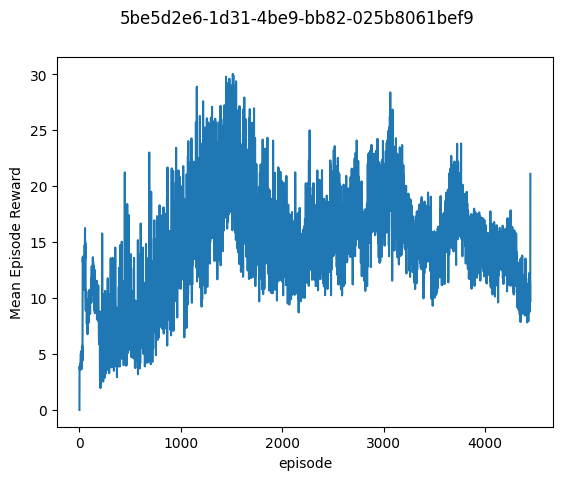

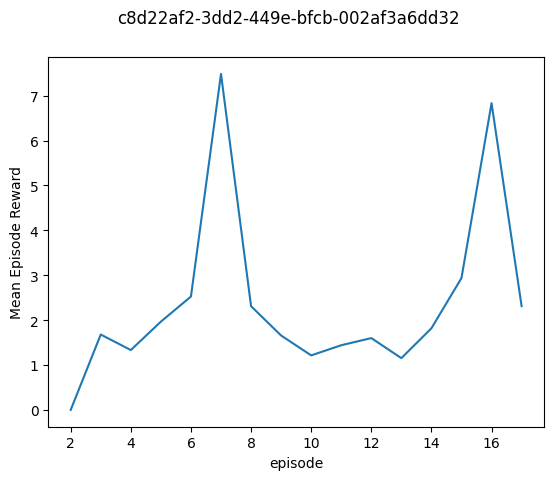

In [144]:
for run_id in list(set([x[0] for x in df_group.index])):
    df_group[run_id].plot(subplots=True, title=run_id)
    plt.ylabel('Mean Episode Reward')
    plt.show()

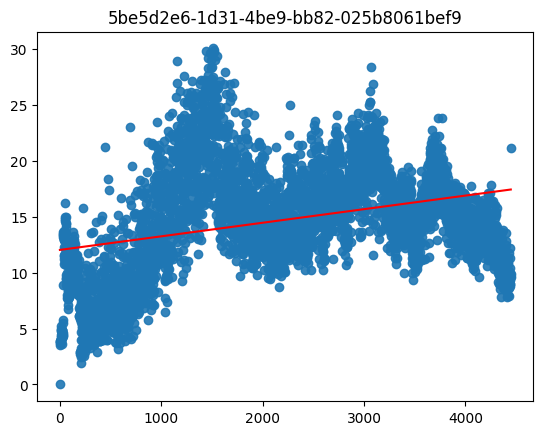

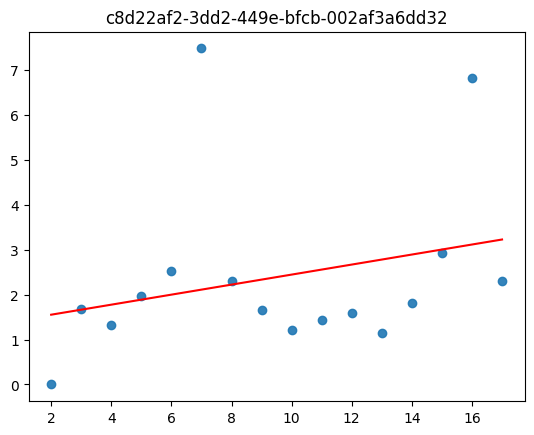

In [41]:
for run_id in list(set([x[0] for x in df_group.index])):
    plt.scatter(df_group[run_id].index, df_group[run_id].reset_index()['reward'], alpha=0.1)
    plt.title(run_id)
    if len(df_group[run_id]) > 10:
        slope, intercept = np.polyfit(df_group[run_id].index, df_group[run_id].reset_index()['reward'], 1)
        plt.plot(df_group[run_id].index, slope * df_group[run_id].index + intercept, 'r')

    plt.show()

In [133]:
#plt.scatter(df['iteration'], df['obs'].apply(lambda x: x['T']), alpha=0.1)
#plt.scatter(df['iteration'], df['obs'].apply(lambda x: x['Tref']), alpha=0.1)

<Axes: >

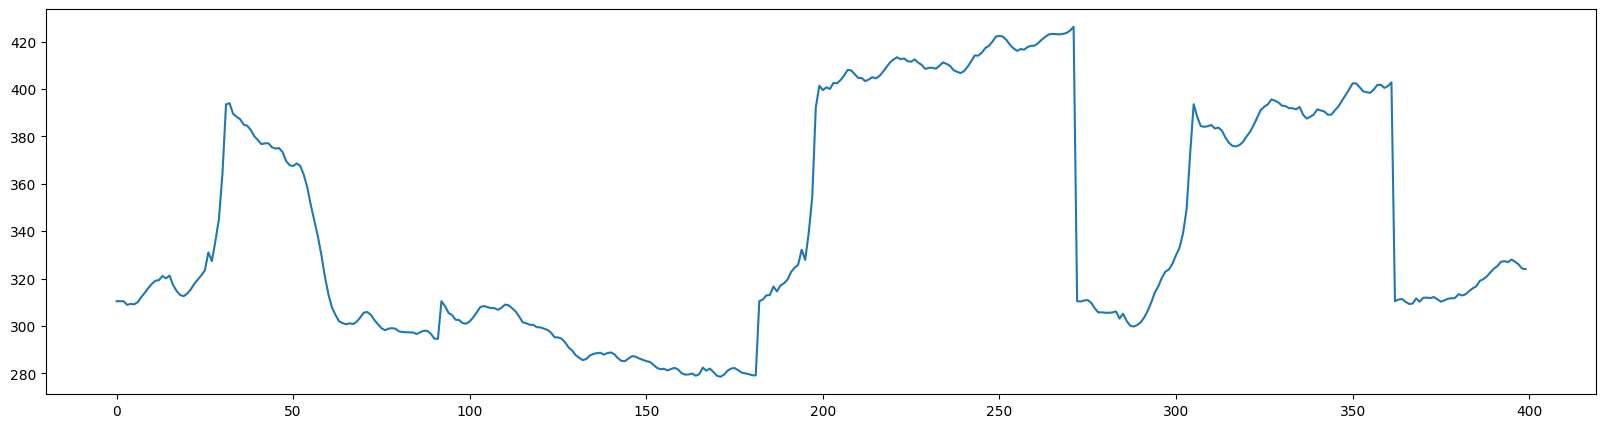

In [145]:
df['obs'].apply(lambda x: x['T'])[:400].plot(figsize=(20,5))

KeyError: 'Tc'

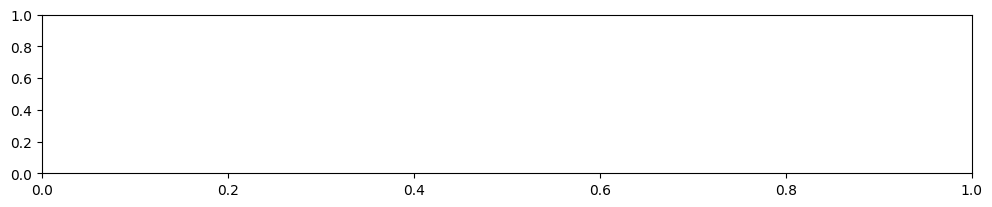

In [146]:
plt.figure(figsize=(12,7))
plt.subplot(3,1,1)
#plt.plot(self.reward_history, 'r.-')
plt.plot(df.reset_index()['time'],df.reset_index()['Tc'])
plt.ylabel('Control Action - Tc')
plt.legend(['reward'],loc='best')

plt.subplot(3,1,2)
#plt.plot(self.rms_history, 'r.-')
plt.plot(df.reset_index()['time'],df.reset_index()['T'])
plt.plot(df.reset_index()['time'],df.reset_index()['Tref'],'r--')
plt.ylabel('Temp')
plt.legend(['T', 'Tref'],loc='best')

plt.subplot(3,1,3)
plt.plot(df.reset_index()['time'],df.reset_index()['Ca'])
plt.plot(df.reset_index()['time'],df.reset_index()['Cref'],'r--')
plt.legend(['Ca', 'Cref'],loc='best')
plt.ylabel('Concentration')
plt.xlabel('iteration')

In [150]:
df['episode'] = df.episode.ffill()
df['skill_name'] = df.skill_name.ffill()

In [151]:
df = df.dropna(subset=['obs'])

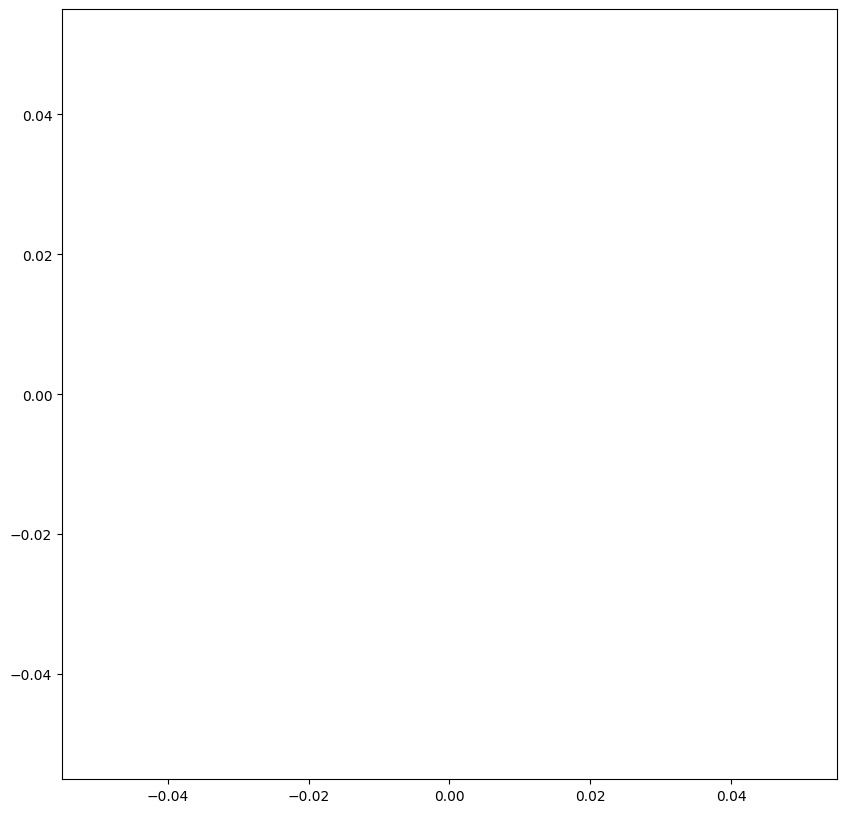

In [152]:
plt.figure(figsize=(10,10))
plt.scatter(df[df['run_id']=='6b102fdd-c0da-42b3-8632-4e44073e0e19']['episode'], df[df['run_id']=='6b102fdd-c0da-42b3-8632-4e44073e0e19']['reward'])
plt.show()

In [ ]:
#conn.close()

# Analayze each run

In [154]:
run_id = '5be5d2e6-1d31-4be9-bb82-025b8061bef9'

In [155]:
print('Max Episode: ', df['episode'].max())
episode = 4447

Max Episode:  4447.0


In [156]:
#FILTER
df_filter = df[df['run_id'] == run_id]

In [157]:
df_filter[df['episode'] == episode]

/var/folders/y5/33d737hn3cg69hxsxbhhh0l80000gn/T/ipykernel_16110/620731692.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_filter[df['episode'] == episode]


,Unnamed: 0,time,run_id,category,category_sub,skill_name,episode,obs,reward,action,iteration
418364,2928552,2023-10-26 17:07:17.571000+00:00,5be5d2e6-1d31-4be9-bb82-025b8061bef9,teacher,compute-reward,reaction,4447.0,"{'T': 311.16053807193197, 'Ca': 8.576382003771...",62.157328,[-0.018157958984375],0
418365,2928563,2023-10-26 17:07:17.571000+00:00,5be5d2e6-1d31-4be9-bb82-025b8061bef9,teacher,compute-reward,reaction,4447.0,"{'T': 311.28652553670565, 'Ca': 8.578750416272...",54.920971,[-0.8885688781738281],1
418366,2928573,2023-10-26 17:07:17.571000+00:00,5be5d2e6-1d31-4be9-bb82-025b8061bef9,teacher,compute-reward,reaction,4447.0,"{'T': 311.020240979809, 'Ca': 8.59501260052549...",39.979849,[-1.8161029815673828],2
418367,2928574,2023-10-26 17:07:17.571000+00:00,5be5d2e6-1d31-4be9-bb82-025b8061bef9,teacher,compute-reward,reaction,4447.0,"{'T': 396.69298350022297, 'Ca': 0.895587503099...",0.538509,[-10.0],3
418368,2928595,2023-10-26 17:07:17.572000+00:00,5be5d2e6-1d31-4be9-bb82-025b8061bef9,teacher,compute-reward,reaction,4447.0,"{'T': 310.93026717929075, 'Ca': 8.584300531250...",67.392034,[-0.34960174560546875],4
418369,2928596,2023-10-26 17:07:17.572000+00:00,5be5d2e6-1d31-4be9-bb82-025b8061bef9,teacher,compute-reward,reaction,4447.0,"{'T': 311.04754853524753, 'Ca': 8.579014894437...",66.917257,[-0.1560983657836914],5
418370,2928600,2023-10-26 17:07:17.572000+00:00,5be5d2e6-1d31-4be9-bb82-025b8061bef9,teacher,compute-reward,reaction,4447.0,"{'T': 310.6848901467057, 'Ca': 8.5996448101492...",54.760421,[-0.09685897827148438],6
418371,2928603,2023-10-26 17:07:17.573000+00:00,5be5d2e6-1d31-4be9-bb82-025b8061bef9,teacher,compute-reward,reaction,4447.0,"{'T': 310.42869614487523, 'Ca': 8.585198651643...",0.000000,[9.305047988891602],7
418372,2928605,2023-10-26 17:07:17.573000+00:00,5be5d2e6-1d31-4be9-bb82-025b8061bef9,teacher,compute-reward,reaction,4447.0,"{'T': 310.7844279464383, 'Ca': 8.5916312151449...",62.552300,[0.14603614807128906],8
418373,2928612,2023-10-26 17:07:17.670000+00:00,5be5d2e6-1d31-4be9-bb82-025b8061bef9,teacher,compute-reward,reaction,4447.0,"{'T': 310.5917956166626, 'Ca': 8.6072414618316...",47.112856,[-0.10364151000976562],9


/var/folders/y5/33d737hn3cg69hxsxbhhh0l80000gn/T/ipykernel_16110/2696221139.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.plot(df_filter[df['episode'] == episode]['iteration'][:88],df_filter[df['episode'] == episode].reset_index()['obs'].apply(lambda x: x['Tref'])[:88])
/var/folders/y5/33d737hn3cg69hxsxbhhh0l80000gn/T/ipykernel_16110/2696221139.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.plot(df_filter[df['episode'] == episode]['iteration'][:88],df_filter[df['episode'] == episode].reset_index()['obs'].apply(lambda x: x['Tref'])[:88])


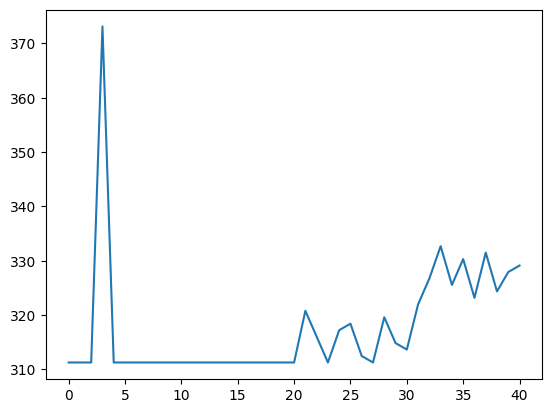

In [158]:
#plt.scatter(df_filter[df['episode'] == episode]['time'][:88],df_filter[df['episode'] == episode].reset_index()['obs'].apply(lambda x: x['T'])[:88])
plt.plot(df_filter[df['episode'] == episode]['iteration'][:88],df_filter[df['episode'] == episode].reset_index()['obs'].apply(lambda x: x['Tref'])[:88])

/var/folders/y5/33d737hn3cg69hxsxbhhh0l80000gn/T/ipykernel_16110/4111285319.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.scatter(df_filter[df['episode'] == episode]['iteration'], df_filter[df['episode'] == episode]['obs'].apply(lambda x: x['T']), alpha=0.9)
/var/folders/y5/33d737hn3cg69hxsxbhhh0l80000gn/T/ipykernel_16110/4111285319.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.scatter(df_filter[df['episode'] == episode]['iteration'], df_filter[df['episode'] == episode]['obs'].apply(lambda x: x['T']), alpha=0.9)
/var/folders/y5/33d737hn3cg69hxsxbhhh0l80000gn/T/ipykernel_16110/4111285319.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.scatter(df_filter[df['episode'] == episode]['iteration'], df_filter[df['episode'] == episode]['obs'].apply(lambda x: x['Tref']), alpha=0.9)
/var/folders/y5/33d737hn3cg69hxsxbhhh0l80000gn/T/ipykernel_16110/4111285319.py:2: UserWarning:

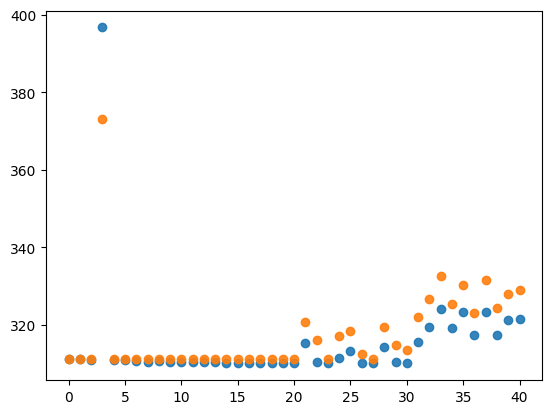

In [159]:
plt.scatter(df_filter[df['episode'] == episode]['iteration'], df_filter[df['episode'] == episode]['obs'].apply(lambda x: x['T']), alpha=0.9)
plt.scatter(df_filter[df['episode'] == episode]['iteration'], df_filter[df['episode'] == episode]['obs'].apply(lambda x: x['Tref']), alpha=0.9)

/var/folders/y5/33d737hn3cg69hxsxbhhh0l80000gn/T/ipykernel_16110/3172287909.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.scatter(df_filter[df['episode'] == episode]['obs'].apply(lambda x: x['Cref']), df_filter[df['episode'] == episode]['obs'].apply(lambda x: x['Ca']), alpha=0.4)
/var/folders/y5/33d737hn3cg69hxsxbhhh0l80000gn/T/ipykernel_16110/3172287909.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.scatter(df_filter[df['episode'] == episode]['obs'].apply(lambda x: x['Cref']), df_filter[df['episode'] == episode]['obs'].apply(lambda x: x['Ca']), alpha=0.4)


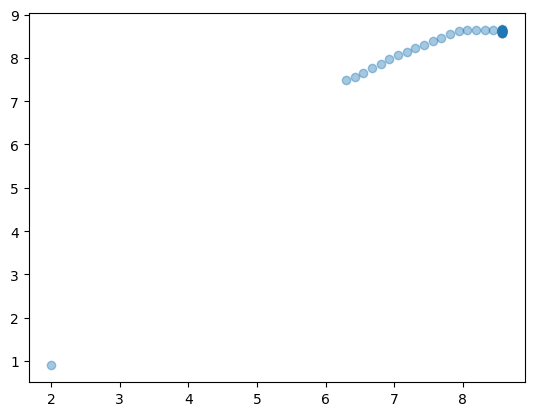

In [160]:
plt.scatter(df_filter[df['episode'] == episode]['obs'].apply(lambda x: x['Cref']), df_filter[df['episode'] == episode]['obs'].apply(lambda x: x['Ca']), alpha=0.4)

/var/folders/y5/33d737hn3cg69hxsxbhhh0l80000gn/T/ipykernel_16110/854742846.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.scatter(df_filter[df['episode'] == episode]['obs'].apply(lambda x: x['Tref']), df_filter[df['episode'] == episode]['obs'].apply(lambda x: x['T']), alpha=0.4)
/var/folders/y5/33d737hn3cg69hxsxbhhh0l80000gn/T/ipykernel_16110/854742846.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.scatter(df_filter[df['episode'] == episode]['obs'].apply(lambda x: x['Tref']), df_filter[df['episode'] == episode]['obs'].apply(lambda x: x['T']), alpha=0.4)


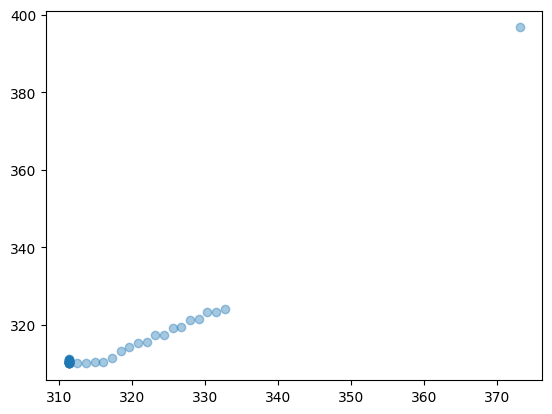

In [161]:
plt.scatter(df_filter[df['episode'] == episode]['obs'].apply(lambda x: x['Tref']), df_filter[df['episode'] == episode]['obs'].apply(lambda x: x['T']), alpha=0.4)

In [66]:
df_filter

,time,run_id,category,category_sub,skill_name,episode,obs,reward,action,iteration
9111,2023-10-26 16:13:47.159000+00:00,5be5d2e6-1d31-4be9-bb82-025b8061bef9,teacher,compute-reward,reaction,2.0,"{'T': 310.42869614487523, 'Ca': 8.585198651643...",0.000000,[0.31863608956336975],0
9116,2023-10-26 16:13:56.145000+00:00,5be5d2e6-1d31-4be9-bb82-025b8061bef9,teacher,compute-reward,reaction,2.0,"{'T': 310.42869614487523, 'Ca': 8.585198651643...",0.000000,[9.353528022766112],1
9124,2023-10-26 16:13:56.164000+00:00,5be5d2e6-1d31-4be9-bb82-025b8061bef9,teacher,compute-reward,reaction,3.0,"{'T': 308.3307059289836, 'Ca': 8.6931014825584...",11.152168,[-9.893667221069336],0
9132,2023-10-26 16:13:56.166000+00:00,5be5d2e6-1d31-4be9-bb82-025b8061bef9,teacher,compute-reward,reaction,3.0,"{'T': 306.1519441364481, 'Ca': 8.7648432614914...",8.026673,[-4.257821083068848],1
9146,2023-10-26 16:13:56.166000+00:00,5be5d2e6-1d31-4be9-bb82-025b8061bef9,teacher,compute-reward,reaction,3.0,"{'T': 309.4133510284074, 'Ca': 8.6516002646156...",14.934165,[-6.120590686798096],2
...,...,...,...,...,...,...,...,...,...,...
2935101,2023-10-26 17:07:24.460000+00:00,5be5d2e6-1d31-4be9-bb82-025b8061bef9,teacher,compute-reward,reaction,203.0,"{'T': 310.42869614487523, 'Ca': 8.585198651643...",0.000000,[9.094171524047852],0
2935103,2023-10-26 17:07:24.460000+00:00,5be5d2e6-1d31-4be9-bb82-025b8061bef9,teacher,compute-reward,reaction,202.0,"{'T': 402.3069485447887, 'Ca': 0.7273880263109...",0.523599,[0.0005283355712890625],0
2935107,2023-10-26 17:07:24.460000+00:00,5be5d2e6-1d31-4be9-bb82-025b8061bef9,teacher,compute-reward,reaction,202.0,"{'T': 402.30805828104366, 'Ca': 0.727358057928...",0.528575,[8.487701416015625e-05],1
2935124,2023-10-26 17:07:24.461000+00:00,5be5d2e6-1d31-4be9-bb82-025b8061bef9,teacher,compute-reward,reaction,202.0,"{'T': 402.3075401032663, 'Ca': 0.7273720587761...",0.525280,[0.00027561187744140625],2
